In [71]:
import math
import pandas as pd
import os

from biopandas.pdb import PandasPdb
import numpy as np

import torch

import scipy.spatial as spa
from tqdm import tqdm

In [72]:
# Input: expects 3xN matrix of points
# Returns such R, t so that rmsd(R @ A + t, B) is min
# Uses Kabsch algorithm (https://en.wikipedia.org/wiki/Kabsch_algorithm)
# R = 3x3 rotation matrix
# t = 3x1 column vector
# This already takes residue identity into account.
def rigid_transform_Kabsch_3D(A, B):
    assert A.shape[1] == B.shape[1]
    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")
    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")


    # find mean column wise: 3 x 1
    centroid_A = np.mean(A, axis=1, keepdims=True)
    centroid_B = np.mean(B, axis=1, keepdims=True)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ Bm.T

    # find rotation
    U, S, Vt = np.linalg.svd(H)

    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        # print("det(R) < R, reflection detected!, correcting for it ...")
        SS = np.diag([1.,1.,-1.])
        R = (Vt.T @ SS) @ U.T
    assert math.fabs(np.linalg.det(R) - 1) < 1e-5

    t = -R @ centroid_A + centroid_B
    return R, t

In [73]:
def compute_rmsd(pred, true):
    return np.sqrt(np.mean(np.sum((pred - true) ** 2, axis=1)))

In [74]:
def get_rmsd_summary(rmsds):
    rmsds_np = np.array(rmsds)
    return {
        'mean': np.mean(rmsds_np),
        'median': np.median(rmsds_np),
        'std': np.std(rmsds_np),
        'lt1': 100 * (rmsds_np < 1.0).sum() / len(rmsds_np),
        'lt2': 100 * (rmsds_np < 2.0).sum() / len(rmsds_np),
        'lt5': 100 * (rmsds_np < 5.0).sum() / len(rmsds_np),
        'lt10': 100 * (rmsds_np < 10.0).sum() / len(rmsds_np)
    }

In [75]:
class RMSDComputer():
    def __init__(self):
        self.complex_rmsd_list = []
        self.ligand_rmsd_list = []
    
    def update_all_rmsd(self, ligand_coors_pred, ligand_coors_true, receptor_coors):
        complex_rmsd = self.update_complex_rmsd(ligand_coors_pred, ligand_coors_true, receptor_coors)
        ligand_rmsd = self.update_ligand_rmsd(ligand_coors_pred, ligand_coors_true)
        return complex_rmsd, ligand_rmsd

    def update_complex_rmsd(self, ligand_coors_pred, ligand_coors_true, receptor_coors):
        complex_coors_pred = np.concatenate((ligand_coors_pred, receptor_coors), axis=0)
        complex_coors_true = np.concatenate((ligand_coors_true, receptor_coors), axis=0)

        R,t = rigid_transform_Kabsch_3D(complex_coors_pred.T, complex_coors_true.T)
        complex_coors_pred_aligned = (R @ complex_coors_pred.T + t).T

        complex_rmsd = compute_rmsd(complex_coors_pred_aligned, complex_coors_true)
        self.complex_rmsd_list.append(complex_rmsd)

        return complex_rmsd

    def update_ligand_rmsd(self, ligand_coors_pred, ligand_coors_true):
        ligand_rmsd = compute_rmsd(ligand_coors_pred, ligand_coors_true)
        self.ligand_rmsd_list.append(ligand_rmsd)
        
        return ligand_rmsd
    
    def summarize(self):
        ligand_rmsd_summarized = get_rmsd_summary(self.ligand_rmsd_list) if self.ligand_rmsd_list else None
        complex_rmsd_summarized = get_rmsd_summary(self.complex_rmsd_list)
        return ligand_rmsd_summarized, complex_rmsd_summarized

In [77]:
input_dir = 'hdock/hdock' 

In [117]:
directories_df = pd.read_csv("hdock/data_file.csv")
directories_df = directories_df[directories_df.split == "test"]
directories = [f"{input_dir}/{path}".replace('.dill', '') for path in directories_df.path.values]
directories = [directory for directory in directories if os.path.exists(f"{directory}/output.pdb")]

In [118]:
def get_coords(pdb_file, atoms_to_keep, model_number=1):
    ppdb = PandasPdb().read_pdb(pdb_file)
    model = ppdb.get_model(model_number)
    df = model.df['ATOM']
    if len(atoms_to_keep) > 1:
        df = df[df.atom_name.apply(lambda atom_name: atom_name in atoms_to_keep)]
    else:
        df = df[df.atom_name == atoms_to_keep[0]]
    return df[['x_coord', 'y_coord', 'z_coord']].to_numpy().squeeze().astype(np.float32)

In [119]:
atoms_to_keep = ("CA", )

In [120]:
pd.set_option('mode.chained_assignment', None) # Remove annoying warnings

meter = RMSDComputer()

Irmsd_meter = RMSDComputer()

all_crmsd = []
all_irmsd = []
all_lrmsd = []

num_test_files = 0

for directory in tqdm(directories):
    ligand_model_file = f"{directory}/output.pdb"
    ligand_gt_file = f"{directory}/ligand_gt.pdb"
    receptor = f"{directory}/receptor.pdb"
    
    if not os.path.exists(ligand_model_file):
        continue

    num_test_files += 1

    ligand_model_coords = get_coords(ligand_model_file, atoms_to_keep)
    ligand_gt_coords = get_coords(ligand_gt_file, atoms_to_keep)
    receptor_coords = get_coords(receptor, atoms_to_keep)

    assert ligand_model_coords.shape[0] == ligand_gt_coords.shape[0]

    ligand_receptor_distance = spa.distance.cdist(ligand_gt_coords, receptor_coords)
    positive_tuple = np.where(ligand_receptor_distance < 8.)
    
    active_ligand = positive_tuple[0]
    active_receptor = positive_tuple[1]
    
    ligand_model_pocket_coors = ligand_model_coords[active_ligand, :]
    ligand_gt_pocket_coors = ligand_gt_coords[active_ligand, :]
    receptor_pocket_coors = receptor_coords[active_receptor, :]

    crmsd, lrmsd = meter.update_all_rmsd(np.array(ligand_model_coords), np.array(ligand_gt_coords), np.array(receptor_coords))

    irmsd = Irmsd_meter.update_complex_rmsd(np.array(ligand_model_pocket_coors), np.array(ligand_gt_pocket_coors), np.array(receptor_pocket_coors))

    all_crmsd.append(crmsd)
    all_lrmsd.append(lrmsd)
    all_irmsd.append(irmsd)

100%|█████████████████████████████████████████| 418/418 [24:30<00:00,  3.52s/it]


In [121]:
meter.__class__ = RMSDComputer
Irmsd_meter.__class__ = RMSDComputer

In [122]:
lrmsd, crmsd = meter.summarize()
_, irmsd = Irmsd_meter.summarize()

In [123]:
crmsd

{'mean': 9.227522261142438,
 'median': 0.5233149826526642,
 'std': 10.735226373266453,
 'lt1': 54.30622009569378,
 'lt2': 55.26315789473684,
 'lt5': 55.50239234449761,
 'lt10': 57.655502392344495}

In [124]:
irmsd

{'mean': 7.751495912712473,
 'median': 0.44862960278987885,
 'std': 9.846088510342211,
 'lt1': 55.26315789473684,
 'lt2': 55.26315789473684,
 'lt5': 56.698564593301434,
 'lt10': 61.004784688995215}

For only CA atoms:
* Ligand rmsd CA median/mean/std: 16.6/28.4 +- 30.3
* Complex rmsd CA median/mean/std: 6.23/10.8 +- 11.4
* Interface complex rmsd CA median/mean/std: 3.9/8.88 +- 11.0

In [125]:
print(f'Number of samples:\t\t{num_test_files}')
print()
print(f"Ligand RMSD median/mean:\t{lrmsd['median']:.3}/{lrmsd['mean']:.3} ± {lrmsd['std']:.3}")
print(f"Complex RMSD median/mean:\t{crmsd['median']:.3}/{crmsd['mean']:.3} ± {crmsd['std']:.3}")
print(f"Interface RMSD median/mean:\t{irmsd['median']:.3}/{irmsd['mean']:.3} ± {irmsd['std']:.3}")
print()
print(f"Ligand lt1/lt2/lt5/lt10,:\t{lrmsd['lt1']:.3}%/{lrmsd['lt2']:.3}%/{lrmsd['lt5']:.3}%/{lrmsd['lt10']:.3}%")
print(f"Complex lt1/lt2/lt5/lt10,:\t{crmsd['lt1']:.3}%/{crmsd['lt2']:.3}%/{crmsd['lt5']:.3}%/{crmsd['lt10']:.3}%")
print(f"Interface lt1/lt2/lt5/lt10,:\t{irmsd['lt1']:.3}%/{irmsd['lt2']:.3}%/{irmsd['lt5']:.3}%/{irmsd['lt10']:.3}%")

Number of samples:		418

Ligand RMSD median/mean:	1.41/23.1 ± 26.8
Complex RMSD median/mean:	0.523/9.23 ± 10.7
Interface RMSD median/mean:	0.449/7.75 ± 9.85

Ligand lt1/lt2/lt5/lt10,:	44.0%/53.8%/55.3%/55.5%
Complex lt1/lt2/lt5/lt10,:	54.3%/55.3%/55.5%/57.7%
Interface lt1/lt2/lt5/lt10,:	55.3%/55.3%/56.7%/61.0%


In [120]:
from matplotlib import pyplot as plt

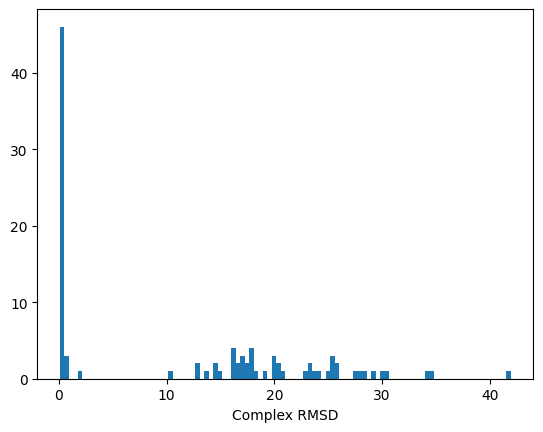

In [125]:
_ = plt.hist(all_crmsd, bins=100)
_ = plt.xlabel("Complex RMSD")

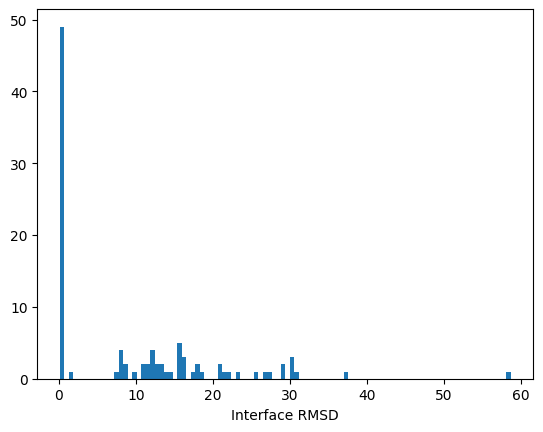

In [126]:
_ = plt.hist(all_irmsd, bins=100)
_ = plt.xlabel("Interface RMSD")

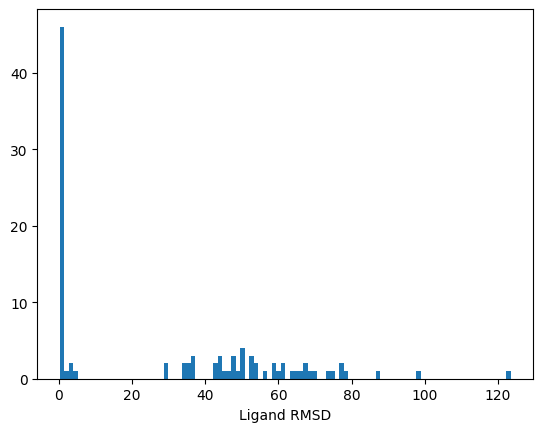

In [128]:
_ = plt.hist(all_lrmsd, bins=100)
_ = plt.xlabel("Ligand RMSD")

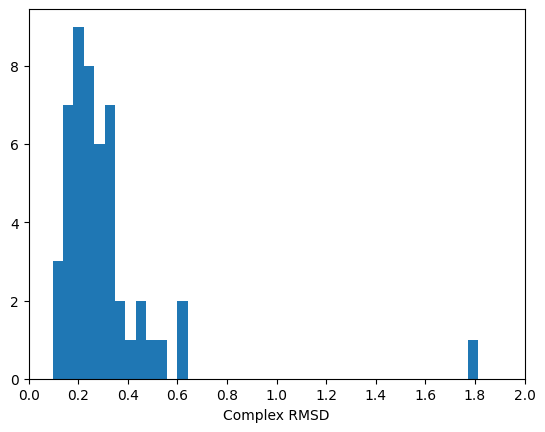

In [198]:
_ = plt.hist(all_crmsd, bins=1000)
_ = plt.xlabel("Complex RMSD")
_ = plt.xlim([0, 2])
_ = plt.xticks(np.linspace(0, 2, 11))

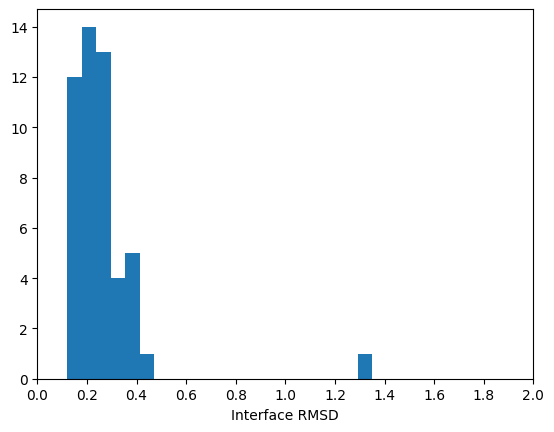

In [195]:
_ = plt.hist(all_irmsd, bins=1000)
_ = plt.xlabel("Interface RMSD")
_ = plt.xlim([0, 2])
_ = plt.xticks(np.linspace(0, 2, 11))

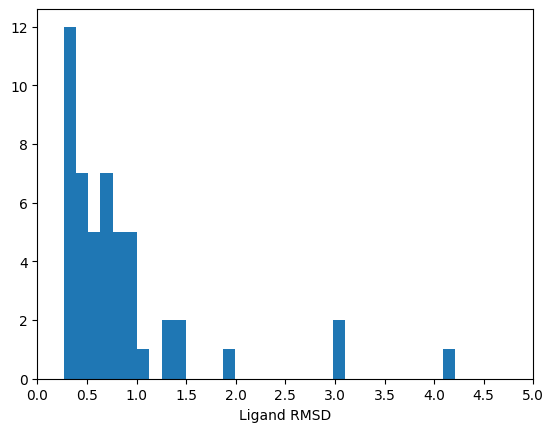

In [194]:
_ = plt.hist(all_lrmsd, bins=1000)
_ = plt.xlabel("Ligand RMSD")
_ = plt.xlim([0, 5])
_ = plt.xticks(np.linspace(0, 5, 11))

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])